In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import time
import datetime
from typing import Dict, Tuple

# Load raw data

In [2]:
data_raw_filename = "data_raw_fake.csv"

In [3]:
dataset = pd.read_csv(data_raw_filename)

In [4]:
dataset.head().T

,0,1,2,3,4
date,2020-11-21 13:00:31,2020-11-21 13:32:31,2020-11-21 13:36:12,2020-11-21 13:37:12,2020-11-21 13:38:55
restaurant,/be/api/restaurants/2,/be/api/restaurants/2,/be/api/restaurants/2,/be/api/restaurants/2,/be/api/restaurants/2
status,2,2,2,2,2
total_cost,30.2,30.2,30.2,30.2,30.2
rest,&{Long:27.554384 Lat:53.890244},&{Long:27.554384 Lat:53.890244},&{Long:27.554384 Lat:53.890244},&{Long:27.554384 Lat:53.890244},&{Long:27.554384 Lat:53.890244}
dest,&{Long:27.599731 Lat:53.925205},&{Long:27.599731 Lat:53.925205},&{Long:27.599731 Lat:53.925205},&{Long:27.599731 Lat:53.925205},&{Long:27.599731 Lat:53.925205}
courier,<nil>,<nil>,<nil>,<nil>,<nil>


In [5]:
dataset.dtypes

date           object
restaurant     object
status        float64
total_cost    float64
rest           object
dest           object
courier        object
dtype: object

In [6]:
dataset.describe()

,status,total_cost
count,81.000000,170.000000
mean,2.629630,14.254118
std,0.914391,15.006993
min,2.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,4.000000,30.200001
max,4.000000,30.200001


# Prepare data

## List categorical columns

In [7]:
categorical_columns = ['restaurant']

In [8]:
def split_column(df: pd.DataFrame, name: str):
    df[name+'_long'] = df[name].str.extract("&{Long:(\d+\.\d+)", expand=False).astype('float64')
    df[name+'_lat'] = df[name].str.extract("Lat:(\d+\.\d+)}", expand=False).astype('float64')
    return df.drop([name], axis=1)

In [9]:
def replace_coordinates(df: pd.DataFrame):
    df = split_column(df, "rest")
    df = split_column(df, "dest")
    df = split_column(df, "courier")
    return df

In [10]:
dataset = replace_coordinates(dataset)

## Geodata

In [11]:
def plot_geodata(dataset: pd.DataFrame): 
    gdf = geopandas.GeoDataFrame(dataset.copy(), 
                                 geometry=geopandas.points_from_xy(dataset.rest_long, dataset.rest_lat))
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    ax = world[world.continent == 'Europe'].plot(color='white', edgecolor='black')

    gdf.plot(ax=ax, color='red',  figsize=(256, 256))

    plt.show()

In [12]:
#plot_geodata(dataset)

##  Handle N/A values

In [13]:
dataset.isna().sum()

date              0
restaurant       89
status           89
total_cost        0
rest_long        89
rest_lat         89
dest_long        89
dest_lat         89
courier_long    121
courier_lat     121
dtype: int64

### Replace other NaN with explicit 'n/a' value

In [14]:
def replace_na_value(dataset: pd.DataFrame):
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
        
        dataset[column] = dataset[column].fillna('n/a')

In [15]:
replace_na_value(dataset)

## Convert columns types
Easier to work with later, handle as generic category

In [16]:
def convert_column_type(dataset, column_name, result_type):
    dataset[column_name] = dataset[column_name].astype(result_type)

In [17]:
convert_column_type(dataset, 'date', 'datetime64')
convert_column_type(dataset, 'restaurant', str)
convert_column_type(dataset, 'status', str)

## State machine - convert events to orders

In [18]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) * 1000

In [19]:
data = []

start_date = None
curr_restaurant = None
curr_total_cost = None
curr_distance = None

rest_lat = None
rest_long = None
dest_lat = None
dest_long = None

for index, row in dataset.iterrows():
    restaurant = str(row['restaurant'])
    if 'n/a' in restaurant:
        if curr_restaurant is not None:
            distance = haversine(rest_lat, rest_long, dest_lat, dest_long)
            total_time_sec = (row['date']-start_date).total_seconds()
            data.append([start_date, curr_restaurant, curr_total_cost, distance, total_time_sec])
            
            curr_restaurant = None
    else:
        if curr_restaurant is None:
            curr_restaurant = restaurant
            start_date = row['date']
            curr_total_cost = row['total_cost']
            
            rest_lat = row['rest_lat']
            rest_long = row['rest_long']
            dest_lat = row['dest_lat']
            dest_long = row['dest_long']
        

df = pd.DataFrame(data, columns=['date', 'restaurant', 'total_cost', 'distance_meters', 'total_time_sec'])

In [20]:
df.dtypes

date               datetime64[ns]
restaurant                 object
total_cost                float64
distance_meters           float64
total_time_sec            float64
dtype: object

In [21]:
df.head().T

,0,1,2,3,4
date,2020-11-21 13:00:31,2020-11-21 16:53:31,2020-11-21 19:53:31,2020-11-21 22:53:31,2020-11-22 16:53:31
restaurant,/be/api/restaurants/2,/be/api/restaurants/2,/be/api/restaurants/2,/be/api/restaurants/2,/be/api/restaurants/2
total_cost,30.2,28.2,27.2,27.2,22.2
distance_meters,4892.42,4892.42,4892.42,4892.42,4892.42
total_time_sec,6811,4047,4047,3927,3447


# TODO: extract month, day, weekday, day time; probably better then pure date

# ===========
# Work with processed data

## Encode categorical columns

In [22]:
def encode_categorical_columns(dataset: pd.DataFrame) -> Dict[str, LabelEncoder]:
    encoders = {} 
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
            
        le = LabelEncoder()
        le.fit(dataset[column])

        dataset[column] = le.transform(dataset[column])
        encoders[column]= le
        
    return encoders

In [23]:
encoders = encode_categorical_columns(df)

## Handle date columns
Convert to epoch time

In [24]:
date_columns = ['date']

In [25]:
def convert_date_columns_to_epoch(dataset: pd.DataFrame, timestamp_format="%Y-%m-%d %H:%M:%S"):
    for column in date_columns:
        dataset[column] = (dataset[column] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [26]:
convert_date_columns_to_epoch(df)

## Scale/normalize all columns

In [27]:
def scale_columns(dataset: pd.DataFrame):
    scaler = StandardScaler()
    dataset = scaler.fit_transform(dataset)
    #dataset[values.columns] = scaler.fit_transform(dataset[dataset.columns])

In [28]:
scale_columns(df)

In [29]:
df.head().T

,0,1,2,3,4
date,1.605964e+09,1.605978e+09,1.605988e+09,1.605999e+09,1.606064e+09
restaurant,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
total_cost,3.020000e+01,2.820000e+01,2.720000e+01,2.720000e+01,2.220000e+01
distance_meters,4.892418e+03,4.892418e+03,4.892418e+03,4.892418e+03,4.892418e+03
total_time_sec,6.811000e+03,4.047000e+03,4.047000e+03,3.927000e+03,3.447000e+03


In [30]:
df.dtypes

date                 int64
restaurant           int64
total_cost         float64
distance_meters    float64
total_time_sec     float64
dtype: object

In [31]:
def prepare_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    encode_categorical_columns(dataset)
    convert_date_columns_to_epoch(dataset)

    scale_columns(dataset)
    
    return dataset

# =======

# Split dataset

In [32]:
def split_dataset(dataset: pd.DataFrame): 
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]

    return train_test_split(X, y, test_size=0.2, random_state = 0)

In [33]:
X_train, X_test, y_train, y_test = split_dataset(df)

# Train models

In [34]:
models_result = {}

In [35]:
def update_result_print(models_result, model_name, regr, X_test, y_test):
    from sklearn.metrics import r2_score
    
    y_pred = regr.predict(X_test)
    y_test = y_test.values.tolist()
    
    print("y_pred:")
    print(y_pred)
    print("y_test:")
    print(y_test)

    accuracy = r2_score(y_test, y_pred)

    models_result[model_name] = accuracy
    print(f'"{model_name}" has r2_score: {accuracy}') 

In [36]:
def plot_features_importances(regressor, X_train):
    series = pd.Series(regressor.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    series = series.plot(kind='barh', figsize=(10,10))
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.show()

## Random forest

In [37]:
def random_forest(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(max_depth=25, n_estimators = 42*5, random_state = 0)

    regr.fit(X_train, y_train)
    
    return regr

y_pred:
[4387.74285714 4090.56190476]
y_test:
[3987.0, 4047.0]
"Random forest" has r2_score: -89.2735983875032


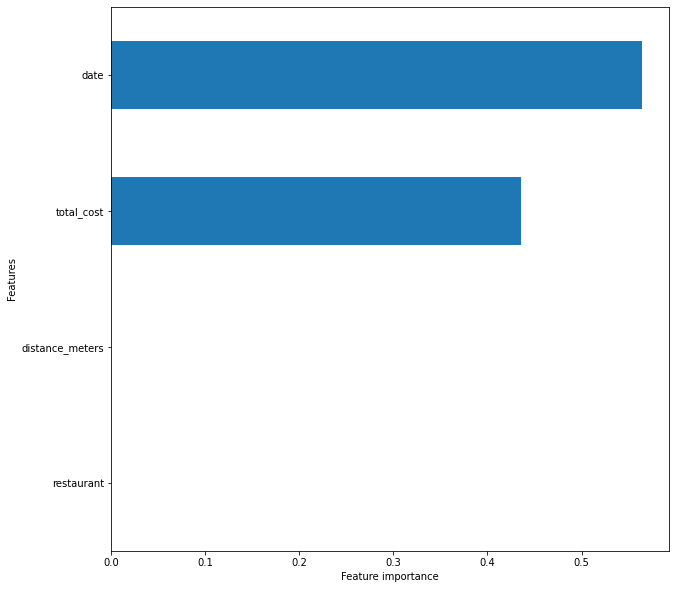

In [38]:
rf_rgr = random_forest(X_train, y_train)
update_result_print(models_result, 'Random forest', rf_rgr, X_test, y_test)
plot_features_importances(rf_rgr, X_train)

## K-Nearest Neighbors

In [39]:
def k_nearest(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    regr = KNeighborsRegressor(n_neighbors=3)
    
    regr.fit(X_train, y_train)
    
    return regr

In [40]:
k_nearest_regr = k_nearest(X_train, y_train)
update_result_print(models_result, 'K-Nearest Neighbors', k_nearest_regr, X_test, y_test)
#plot_features_importances(k_nearest_regr, X_train)

y_pred:
[4007.         4928.33333333]
y_test:
[3987.0, 4047.0]
"K-Nearest Neighbors" has r2_score: -430.74913580246886


## Linear regression

In [41]:
def linear(X_train, y_train):
    from sklearn.linear_model import LinearRegression
    regr = LinearRegression()
    
    regr.fit(X_train, y_train)
    
    return regr

In [42]:
linear_regr = linear(X_train, y_train)
update_result_print(models_result, 'Linear', linear_regr, X_test, y_test)
#plot_features_importances(linear_regr, X_train)

y_pred:
[6832.27799741 4417.0480044 ]
y_test:
[3987.0, 4047.0]
"Linear" has r2_score: -4572.63467117558


## Ridge regression

In [43]:
def ridge(X_train, y_train):
    from sklearn.linear_model import Ridge
    regr = Ridge(alpha=.5)
    
    regr.fit(X_train, y_train)
    
    return regr

In [44]:
ridge_regr = ridge(X_train, y_train)
update_result_print(models_result, 'Ridge', ridge_regr, X_test, y_test)
#plot_features_importances(ridge_regr, X_train)

y_pred:
[6629.30322551 4450.3734474 ]
y_test:
[3987.0, 4047.0]
"Ridge" has r2_score: -3968.1535964481322


## Multi-layer perceptron
TODO requires OneHotEncoder

In [45]:
def mlp(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    regr = MLPRegressor(solver='adam', alpha=1e-5,
                        hidden_layer_sizes=(X_train.columns.size, X_train.columns.size), 
                        max_iter=10, activation='relu',
                        learning_rate_init=.1,
                        random_state=0)
    
    regr.fit(X_train, y_train)
    
    return regr

In [46]:
mlp_regr = mlp(X_train, y_train)
update_result_print(models_result, 'Multi-layer perceptron', mlp_regr, X_test, y_test)
#plot_features_importances(mlp_regr, X_train)

y_pred:
[1.67271203 1.67271203]
y_test:
[3987.0, 4047.0]
"Multi-layer perceptron" has r2_score: -17914.28136615164


/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Support Vector Machine

In [47]:
def svm(X_train, y_train):
    from sklearn.svm import LinearSVR 
    regr = LinearSVR()
    
    regr.fit(X_train, y_train)
    
    return regr

In [48]:
svm_regr = svm(X_train, y_train)
update_result_print(models_result, 'Support Vector Machine', svm_regr, X_test, y_test)
#plot_features_importances(svm_regr, X_train)

y_pred:
[0. 0.]
y_test:
[3987.0, 4047.0]
"Support Vector Machine" has r2_score: -17929.21


/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Results

In [49]:
for k,v in sorted(models_result.items(), key=lambda entry:entry[1], reverse=True):
    print(f'{k:25s} {v}')

Random forest             -89.2735983875032
K-Nearest Neighbors       -430.74913580246886
Ridge                     -3968.1535964481322
Linear                    -4572.63467117558
Multi-layer perceptron    -17914.28136615164
Support Vector Machine    -17929.21
